# Problem 6

In [ ]:
# Install packages and dependencies
!pip install torch_geometric

import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

!pip install torch_geometric_temporal

In [50]:
# Import libraries

import numpy as np
import networkx as nx
from tqdm.notebook import tqdm
from collections import Counter
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch import no_grad, cat
import torch.nn.functional as F
from torch.cuda import is_available

from torch_geometric.nn import GCNConv, SAGEConv, GATConv
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx, negative_sampling
from torch_geometric.transforms import RandomLinkSplit

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [5]:
device = 'cpu'
if is_available():
	device = 'gpu'

print(f'Using device {device}')

Using device cpu


---

## Exploratory Data Analysis

In this problem we utilize the PubMed dataset, a citation network with nodes representing scientific publications from the PubMed database, primarily in the biomedical field. Edges indicate citations between these publications. Training, validation and test splits are given by binary masks. Each node features a $TF-IDF$ weighted word vector from the publication's abstract from a dictionary which consists of $500$ unique words and a class label that denotes the publication's subject category.  <br>
Let's take a better look at the dataset.



In [6]:
# Import dataset
dataset = Planetoid(root = '/tmp/Cora', name = 'PubMed')
dataset

Processing...
Done!


PubMed()

### 1) Network Structure

We start our EDA assessing the number of publications (nodes), citation links (edges), average citations per publication, citation distribution, and clustering coefficient.

In [13]:
dataset

PubMed()

In [7]:
data = dataset[0]
data

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

In [8]:
# Graph features (tf-idf values)
data.x

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0194, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
        [0.1078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0266, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [9]:
# Graph edges
data.edge_index.T

tensor([[ 1378,     0],
        [ 1544,     0],
        [ 6092,     0],
        ...,
        [12278, 19714],
        [ 4284, 19715],
        [16030, 19716]])

In [10]:
# Graph visualization
def convert_to_networkx(graph):
	g = to_networkx(graph, node_attrs=['x'])
	y = graph.y.numpy()
	return g, y

def plot_graph(g, y):
	plt.figure(figsize=(9,7))
	plt.title('The PubMed graph dataset', fontsize = 15)
	nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
	plt.savefig('pubmed_graph.png')
	plt.show()

In [27]:
# CAREFUL: IT TAKES > 25 mins on CPU (18 on GPU)
#g, y = convert_to_networkx(data)
#plot_graph(g, y)

In [11]:
# Inspecting dataset characteristics
# - Number of publications (nodes)
# - Number of citation links (edges)
# - Average citations per publication
# - Clustering coefficient
num_nodes = data.num_nodes
print(f'Number of publications (nodes): {num_nodes}')
num_edges = data.num_edges
print(f'Number of citation links (edges): {num_edges}')
avg_cit = num_edges / num_nodes
print(f'Average citations per publication: {avg_cit:.2f}')
# convert to NetworkX graph for easier computation
G = to_networkx(data, to_undirected = True)
clustering_coefficients = nx.clustering(G)
avg_clustering_coefficient = sum(clustering_coefficients.values()) / num_nodes
print(f'Average clustering coefficient: {avg_clustering_coefficient:.4f}')

Number of publications (nodes): 19717
Number of citation links (edges): 88648
Average citations per publication: 4.50
Average clustering coefficient: 0.0602


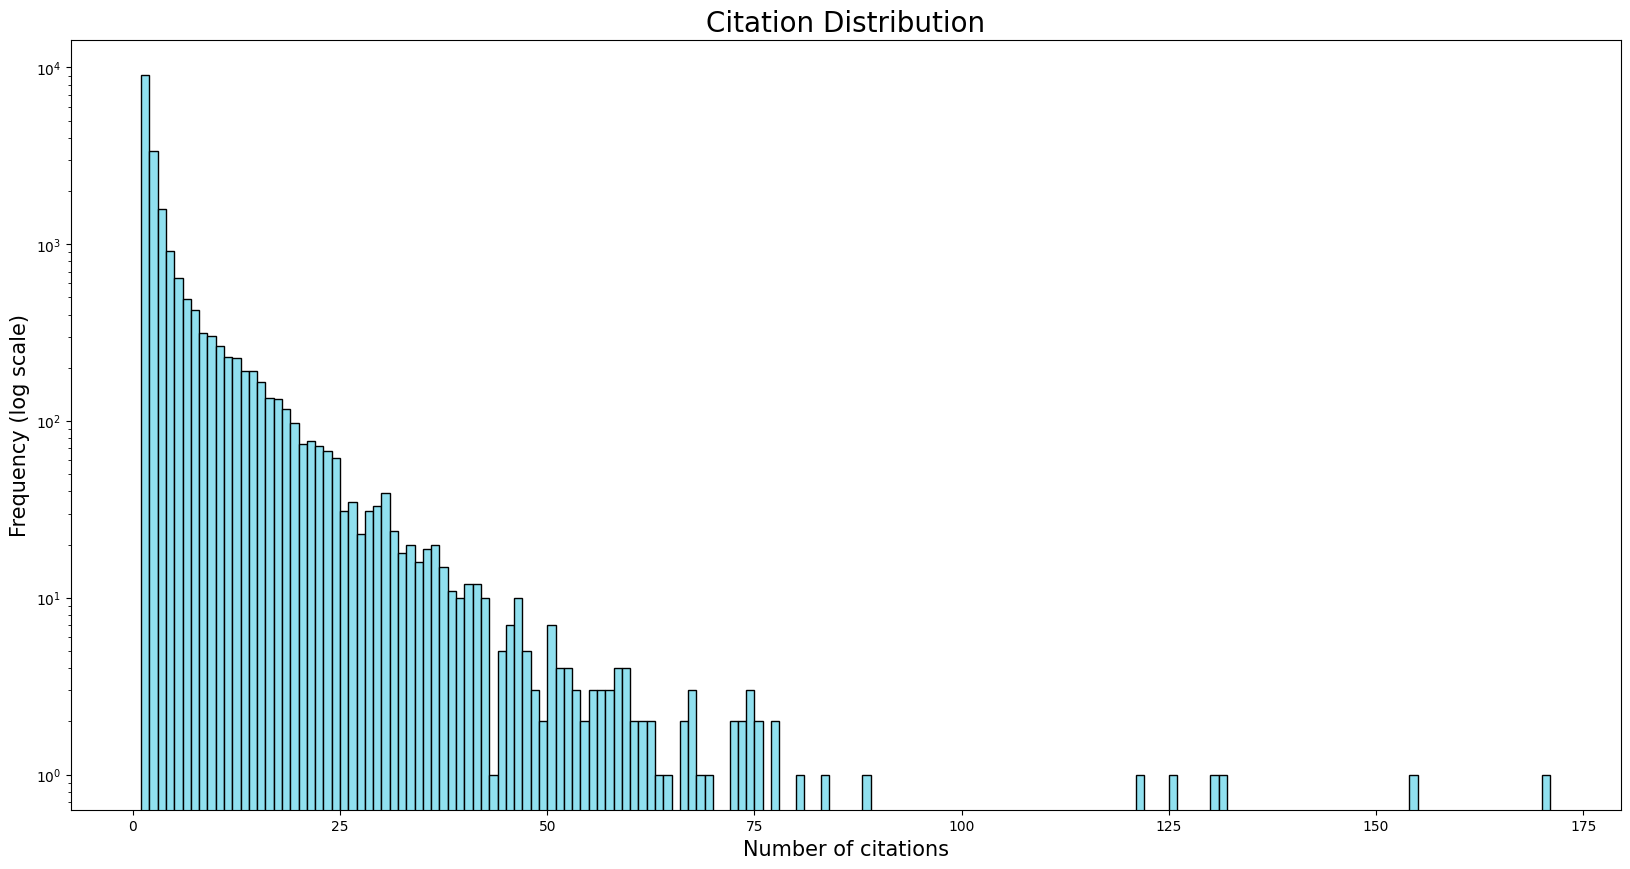

In [12]:
# Citation (degree) distribution
citation_counts = Counter(data.edge_index[1].tolist())
citations = list(citation_counts.values())

# Plot citation distribution
plt.figure(figsize = (20, 10))
plt.hist(citations, bins = range(1, max(citations) + 1), color = '#90e0ef', edgecolor = 'black', log = True)
plt.title('Citation Distribution', fontsize = 20)
plt.xlabel('Number of citations', fontsize = 15)
plt.ylabel('Frequency (log scale)', fontsize = 15)
#plt.savefig('citation_distribution.png')
plt.show()

### 2) Network Features

Here we examine the spread of $TF-IDF$ values and explore potential correlations between word frequencies and publication categories. <br>
Recall that $TF-IDF$ combines two metrics:

- Term Frequency $TF$, measuring how frequently a term) appears in a document.

  $$
  TF(t, d) = \frac{\text{Number of times term $t$ appears in document $d$}}{\text{Total number of terms in document $d$}}
  $$

- Inverse Document Frequency $IDF$, measuring how important a term is across a collection of documents.

  $$
  IDF(t) = log ( \frac{\text{Total number of documents}}{\text{Number of documents containing the term $t$}} ) + 1
  $$

The $TF-IDF$ value for a term $t$ in a document $d$ is obtained by multiplying both quantities:

$$
TF-IDF(t, d) = TF(t,d) \cdot IDF(t)
$$

This value is proportional to the number of times that $t$ appears in a document, but is also inversely proportional to the frequency of $t$ in the collection of documents. This behaviour realizes the idea of giving more importance to the terms that do appear in the document, but are in general not too frequent.

In [14]:
torch.min(data.x), torch.max(data.x)

(tensor(0.), tensor(1.2633))

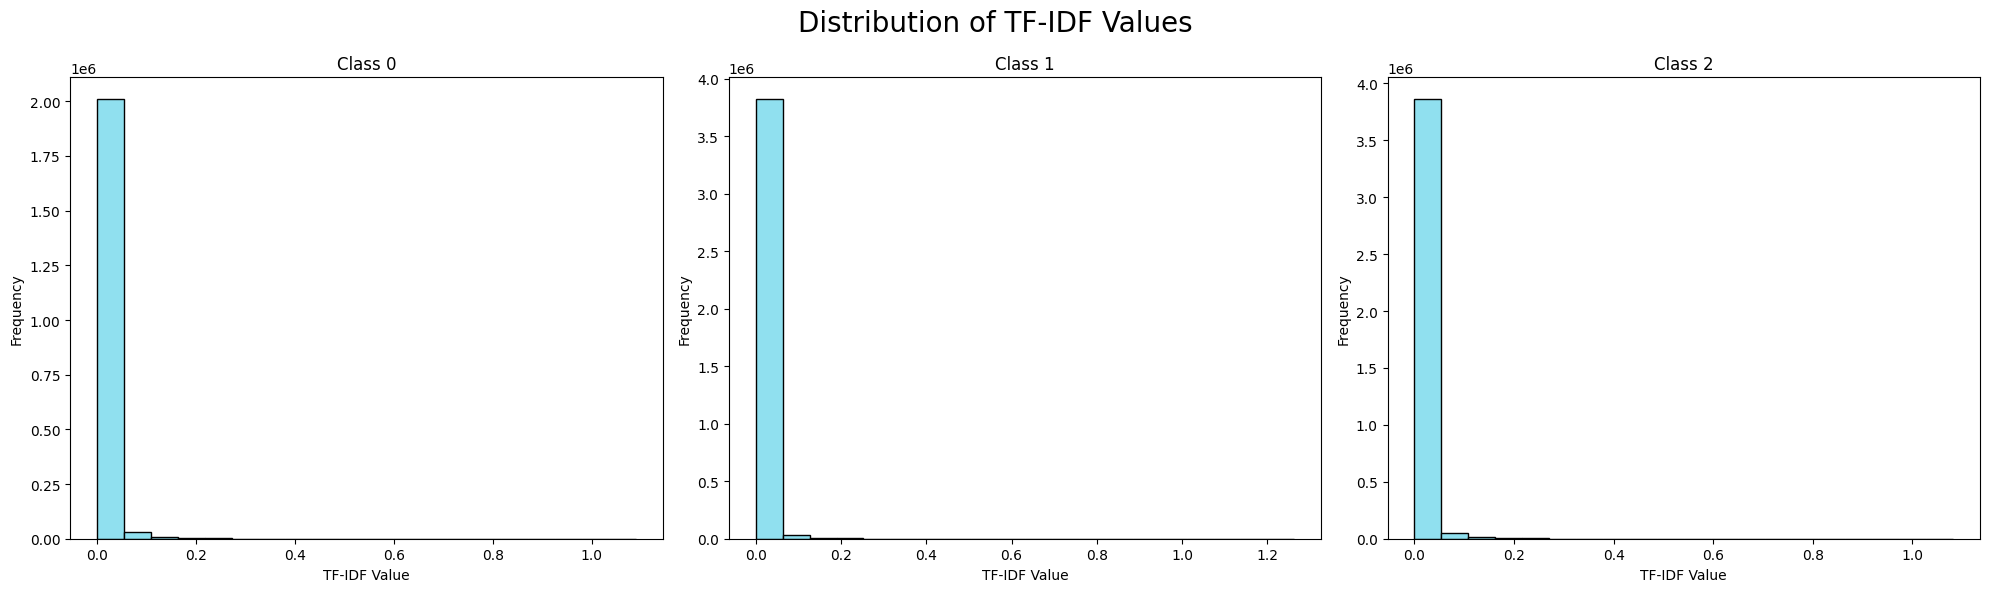

In [17]:
# Visualize TF-IDF distribution
def plot_tfidf_distribution(data, class_label, ax):
    class_mask = data.y == class_label
    tfidf_values_class = data.x[class_mask]
    tfidf_values_flat = tfidf_values_class.view(-1).cpu().numpy()

    ax.hist(tfidf_values_flat, bins=20, color = '#90e0ef', edgecolor='black')
    ax.set_xlabel('TF-IDF Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Class {class_label}')

# For each class
num_classes = torch.max(data.y).item() + 1

fig, axs = plt.subplots(1, num_classes, figsize = (20, 6))

for i in range(num_classes):
    plot_tfidf_distribution(data, i, axs[i])

fig.suptitle('Distribution of TF-IDF Values', fontsize = 20)
plt.tight_layout()
#plt.savefig('tfidf_distribution.png')
plt.show()


### 3) Class distribution

Class distribution: [(0, 4103), (1, 7739), (2, 7875)] 



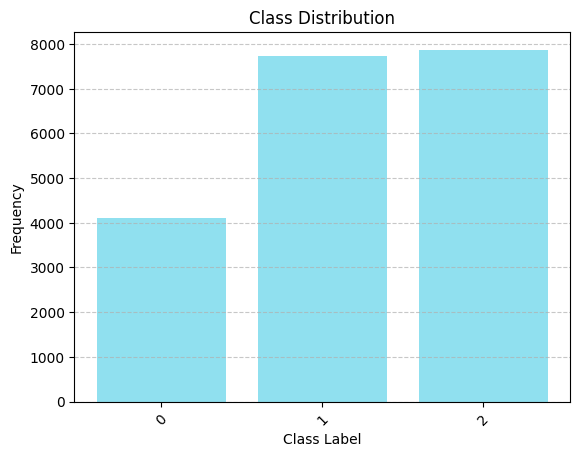

In [19]:
# Extract class labels and their frequencies
class_counts = Counter(data.y.tolist())
print("Class distribution:", sorted(class_counts.items()), "\n")

# Plot the class distribution
plt.bar(class_counts.keys(), class_counts.values(), color='#90e0ef')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(range(len(class_counts)), sorted(class_counts.keys()), rotation = 45, ha = 'center')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
# alpha is the transparency, from 0 (totally transparent) to 1 (totally opaque)
#plt.savefig('class_distribution.png')
plt.show()

The class names are not directly provided within the PubMed dataset object of the Planetoid provider. However, we know they are three and labeled with numbers $0, 1, 2$. Their frequency is showd in the above graph. We can notice that, while class $1$ and $2$ contain almost the same number of documents (nodes), class $0$ appears quite imbalanced with respect to the other two.

---

## Tasks

### Node Classification

Construct and train a Graph Neural Network (GNN) to categorize publications
within the PubMed dataset into their corresponding subject categories. Test different GNN architectures like GCN, GraphSAGE, and GAT.

In [ ]:
# Utility functions to plot training loss and validation accuracy

classification_models = {1:"GCN", 2:"SAGE", 3:"GAT", 4:"Mix"}

def plot_loss_acc(train_lss_curve, val_acc_curve, number, save = False, n_epochs = 100):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
  # Training loss
  ax1.plot(range(n_epochs), train_lss_curve, label = 'Train Loss')
  ax1.set_title(f'{classification_models[number]} Training Loss Curve', fontsize = 15)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
  # Validation accuracy
  ax2.plot(range(n_epochs), val_acc_curve, label = 'Val Accuracy', color = 'orange')
  ax2.set_title(f'{classification_models[number]} Validation Accuracy Curve', fontsize = 15)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  if save:
    plt.savefig(f'curves_{classification_models[number]}.png')
  plt.show()

In [20]:
split = T.RandomNodeSplit(num_val = 0.1, num_test = 0.2)
graph = split(data)
graph

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

#### GCN model

In [6]:
# Try GCN model with 3 layers, with/without dropout, with relu/leaky relu
class GCNModel(nn.Module):
    def __init__(self, dataset, hidden_channels = 32): # , dropout=0.5
        super().__init__()

        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, dataset.num_classes)
        #self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x) #x = F.relu(x)
        #x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        #x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

In [7]:
def eval_node_classifier(model, graph, mask):
	model.eval()

	pred		= model(graph).argmax(dim=1)
	correct	= (pred[mask] == graph.y[mask]).sum()
	acc 		= correct/mask.sum()

	return acc

def train_node_classifier(model, graph, optimizer, criterion, n_epochs = 200):

  train_lss_curve = []
  val_acc_curve = []

  for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()

    out 	= model(graph)
    loss	= criterion(out[graph.train_mask], graph.y[graph.train_mask])

    train_lss_curve.append(loss.item())

    loss.backward()
    optimizer.step()

    acc		= eval_node_classifier(model, graph, graph.val_mask)
    val_acc_curve.append(acc.item())

    if epoch % 5 == 0:
      print(f'Epoch: {epoch}, Train loss: {loss:.3f}, Val accuracy: {acc:.3f}')

  return model, train_lss_curve, val_acc_curve

In [8]:
lr = 0.01
wd = 5e-4
n_epochs = 100

gcn = GCNModel(dataset).to(device)
optimizer_gcn = Adam(gcn.parameters(), lr = lr, weight_decay = wd)
criterion = nn.CrossEntropyLoss()
gcn, train_lss_curve_gcn, val_acc_curve_gcn  = train_node_classifier(gcn, graph, optimizer_gcn, criterion, n_epochs)

test_acc_gcn = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test accuracy {test_acc_gcn:.2f}%')

Epoch: 5, Train loss: 1.034, Val accuracy: 0.452
Epoch: 10, Train loss: 0.919, Val accuracy: 0.658
Epoch: 15, Train loss: 0.752, Val accuracy: 0.759
Epoch: 20, Train loss: 0.576, Val accuracy: 0.816
Epoch: 25, Train loss: 0.457, Val accuracy: 0.839
Epoch: 30, Train loss: 0.415, Val accuracy: 0.852
Epoch: 35, Train loss: 0.395, Val accuracy: 0.856
Epoch: 40, Train loss: 0.381, Val accuracy: 0.865
Epoch: 45, Train loss: 0.375, Val accuracy: 0.860
Epoch: 50, Train loss: 0.370, Val accuracy: 0.863
Epoch: 55, Train loss: 0.362, Val accuracy: 0.861
Epoch: 60, Train loss: 0.357, Val accuracy: 0.865
Epoch: 65, Train loss: 0.352, Val accuracy: 0.869
Epoch: 70, Train loss: 0.348, Val accuracy: 0.873
Epoch: 75, Train loss: 0.345, Val accuracy: 0.870
Epoch: 80, Train loss: 0.343, Val accuracy: 0.869
Epoch: 85, Train loss: 0.338, Val accuracy: 0.872
Epoch: 90, Train loss: 0.337, Val accuracy: 0.873
Epoch: 95, Train loss: 0.336, Val accuracy: 0.875
Epoch: 100, Train loss: 0.332, Val accuracy: 0.872


In [9]:
# Model structure
gcn

GCNModel(
  (conv1): GCNConv(500, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 3)
)

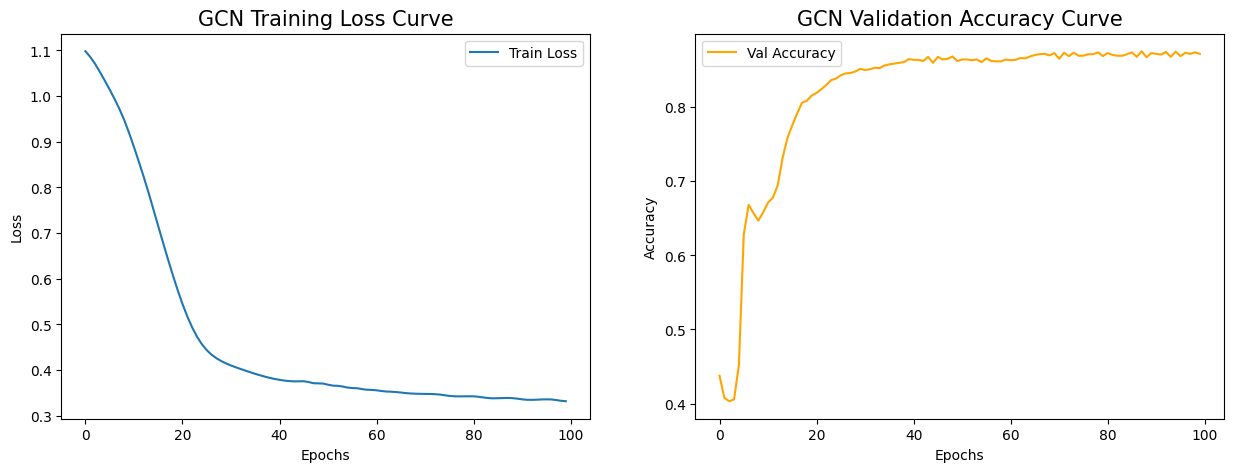

In [11]:
plot_loss_acc(train_lss_curve_gcn, val_acc_curve_gcn, 1, False)

In [12]:
# Print number of parameters
gcn_total_params = sum(p.numel() for p in gcn.parameters() if p.requires_grad)
print(f'Total number of parameters: {gcn_total_params}')

Total number of parameters: 17187


#### SAGE model

In [13]:
# Model with SAGEConv
class SAGEModel(nn.Module):
    def __init__(self, dataset, hidden_channels = 32): #hidden_channel = 16, dropout=0.5
        super(SAGEModel, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        #self.dropout = dropout
        self.conv3 = SAGEConv(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        #x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv3(x, edge_index)

        return x

In [14]:
lr = 0.01
wd = 5e-4
n_epochs = 100

sage = SAGEModel(dataset).to(device)
optimizer_sage = Adam(sage.parameters(), lr = lr, weight_decay = wd)
criterion = nn.CrossEntropyLoss()
sage, train_lss_curve_sage, val_acc_curve_sage  = train_node_classifier(sage, graph, optimizer_sage, criterion, n_epochs)

test_acc_sage = eval_node_classifier(sage, graph, graph.test_mask)
print(f'Test accuracy {test_acc_sage:.2f}%')

Epoch: 5, Train loss: 0.996, Val accuracy: 0.663
Epoch: 10, Train loss: 0.742, Val accuracy: 0.687
Epoch: 15, Train loss: 0.489, Val accuracy: 0.831
Epoch: 20, Train loss: 0.431, Val accuracy: 0.848
Epoch: 25, Train loss: 0.391, Val accuracy: 0.858
Epoch: 30, Train loss: 0.361, Val accuracy: 0.869
Epoch: 35, Train loss: 0.346, Val accuracy: 0.872
Epoch: 40, Train loss: 0.319, Val accuracy: 0.874
Epoch: 45, Train loss: 0.298, Val accuracy: 0.881
Epoch: 50, Train loss: 0.280, Val accuracy: 0.887
Epoch: 55, Train loss: 0.264, Val accuracy: 0.889
Epoch: 60, Train loss: 0.258, Val accuracy: 0.891
Epoch: 65, Train loss: 0.243, Val accuracy: 0.892
Epoch: 70, Train loss: 0.234, Val accuracy: 0.897
Epoch: 75, Train loss: 0.224, Val accuracy: 0.900
Epoch: 80, Train loss: 0.217, Val accuracy: 0.900
Epoch: 85, Train loss: 0.213, Val accuracy: 0.899
Epoch: 90, Train loss: 0.203, Val accuracy: 0.905
Epoch: 95, Train loss: 0.206, Val accuracy: 0.891
Epoch: 100, Train loss: 0.210, Val accuracy: 0.896


In [15]:
# Model structure
sage

SAGEModel(
  (conv1): SAGEConv(500, 32, aggr=mean)
  (conv2): SAGEConv(32, 32, aggr=mean)
  (conv3): SAGEConv(32, 3, aggr=mean)
)

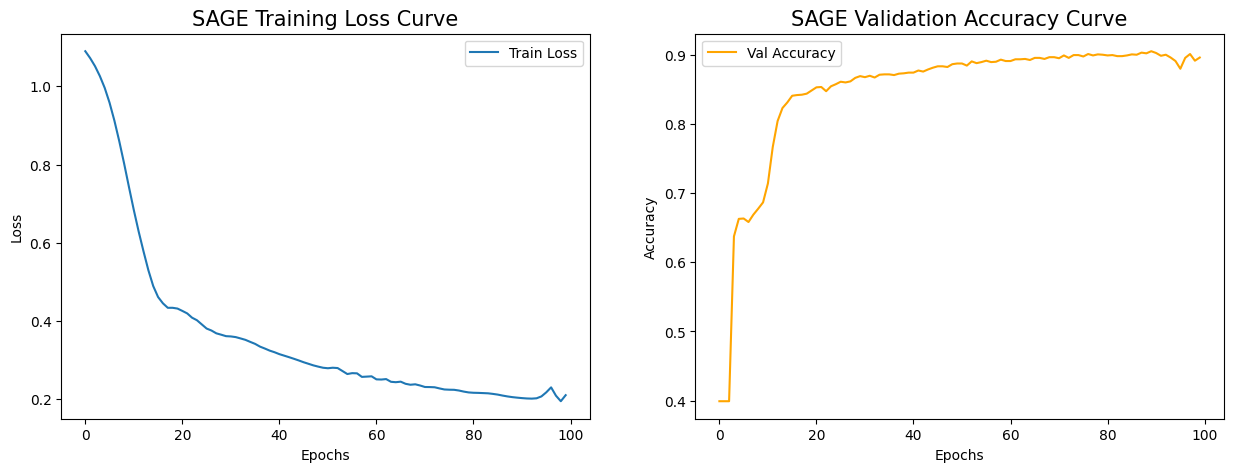

In [16]:
plot_loss_acc(train_lss_curve_sage, val_acc_curve_sage, 2, False)

In [17]:
# Print number of parameters
sage_total_params = sum(p.numel() for p in sage.parameters() if p.requires_grad)
print(f'Total number of parameters: {sage_total_params}')

Total number of parameters: 34307


#### GAT model

In [18]:
# Model with GATConv
class GATModel(nn.Module):
    def __init__(self, dataset, hidden_channels=32, heads=8, dropout=0.5):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(dataset.num_node_features, hidden_channels, heads = heads, dropout = dropout)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads = 1, concat = False, dropout = dropout)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p = self.dropout, training = self.training)
        x = self.conv2(x, edge_index)
        return x

In [19]:
lr = 0.01
wd = 5e-4
n_epochs = 100

gat = GATModel(dataset).to(device)
optimizer_gat = Adam(gat.parameters(), lr = lr, weight_decay = wd)
criterion = nn.CrossEntropyLoss()
gat, train_lss_curve_gat, val_acc_curve_gat  = train_node_classifier(gat, graph, optimizer_gat, criterion, n_epochs)

test_acc_gat = eval_node_classifier(gat, graph, graph.test_mask)
print(f'Test accuracy {test_acc_gat:.2f}%')

Epoch: 5, Train loss: 0.840, Val accuracy: 0.778
Epoch: 10, Train loss: 0.641, Val accuracy: 0.816
Epoch: 15, Train loss: 0.584, Val accuracy: 0.849
Epoch: 20, Train loss: 0.560, Val accuracy: 0.863
Epoch: 25, Train loss: 0.550, Val accuracy: 0.869
Epoch: 30, Train loss: 0.551, Val accuracy: 0.871
Epoch: 35, Train loss: 0.542, Val accuracy: 0.867
Epoch: 40, Train loss: 0.528, Val accuracy: 0.870
Epoch: 45, Train loss: 0.527, Val accuracy: 0.871
Epoch: 50, Train loss: 0.525, Val accuracy: 0.872
Epoch: 55, Train loss: 0.523, Val accuracy: 0.874
Epoch: 60, Train loss: 0.514, Val accuracy: 0.874
Epoch: 65, Train loss: 0.511, Val accuracy: 0.873
Epoch: 70, Train loss: 0.513, Val accuracy: 0.874
Epoch: 75, Train loss: 0.512, Val accuracy: 0.874
Epoch: 80, Train loss: 0.508, Val accuracy: 0.872
Epoch: 85, Train loss: 0.508, Val accuracy: 0.873
Epoch: 90, Train loss: 0.508, Val accuracy: 0.873
Epoch: 95, Train loss: 0.505, Val accuracy: 0.870
Epoch: 100, Train loss: 0.505, Val accuracy: 0.871


In [20]:
# Model structure
gat

GATModel(
  (conv1): GATConv(500, 32, heads=8)
  (conv2): GATConv(256, 3, heads=1)
)

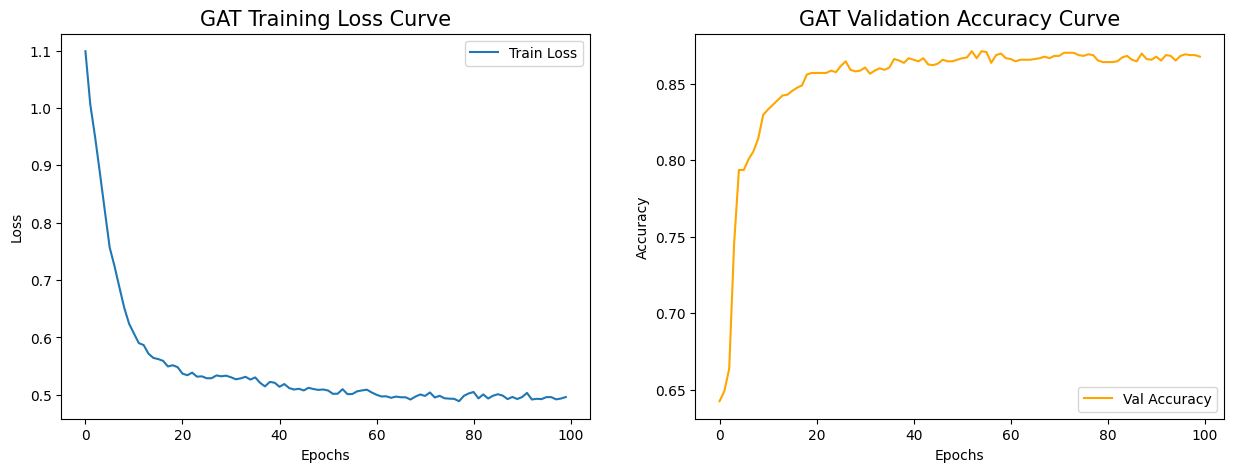

In [45]:
plot_loss_acc(train_lss_curve_gat, val_acc_curve_gat, 3, False)

In [21]:
# Print number of parameters
gat_total_params = sum(p.numel() for p in gat.parameters() if p.requires_grad)
print(f'Total number of parameters: {gat_total_params}')

Total number of parameters: 129545


#### Mixed model

In [22]:
# Model with mixed layers (GCNConv + SAGEConv + GATConv)
class MixModel(nn.Module):
    def __init__(self, dataset, hidden_channels = 32, gat_heads = 8, dropout = 0.5):
        super(MixModel, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads = gat_heads, concat = False, dropout = dropout)
        self.conv3 = SAGEConv(hidden_channels, dataset.num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

In [23]:
lr = 0.01
wd = 5e-4
n_epochs = 100

mix = MixModel(dataset).to(device)
optimizer_mix = Adam(mix.parameters(), lr = lr, weight_decay = wd)
criterion = nn.CrossEntropyLoss()
mix, train_lss_curve_mix, val_acc_curve_mix  = train_node_classifier(mix, graph, optimizer_mix, criterion, n_epochs)

test_acc_mix = eval_node_classifier(mix, graph, graph.test_mask)
print(f'Test accuracy {test_acc_mix:.2f}%')

Epoch: 5, Train loss: 1.032, Val accuracy: 0.399
Epoch: 10, Train loss: 0.906, Val accuracy: 0.528
Epoch: 15, Train loss: 0.768, Val accuracy: 0.678
Epoch: 20, Train loss: 0.622, Val accuracy: 0.701
Epoch: 25, Train loss: 0.542, Val accuracy: 0.828
Epoch: 30, Train loss: 0.494, Val accuracy: 0.855
Epoch: 35, Train loss: 0.445, Val accuracy: 0.849
Epoch: 40, Train loss: 0.421, Val accuracy: 0.855
Epoch: 45, Train loss: 0.399, Val accuracy: 0.854
Epoch: 50, Train loss: 0.387, Val accuracy: 0.860
Epoch: 55, Train loss: 0.376, Val accuracy: 0.865
Epoch: 60, Train loss: 0.365, Val accuracy: 0.869
Epoch: 65, Train loss: 0.351, Val accuracy: 0.873
Epoch: 70, Train loss: 0.348, Val accuracy: 0.875
Epoch: 75, Train loss: 0.343, Val accuracy: 0.871
Epoch: 80, Train loss: 0.337, Val accuracy: 0.873
Epoch: 85, Train loss: 0.333, Val accuracy: 0.868
Epoch: 90, Train loss: 0.328, Val accuracy: 0.878
Epoch: 95, Train loss: 0.332, Val accuracy: 0.879
Epoch: 100, Train loss: 0.323, Val accuracy: 0.881


In [24]:
# Model structure
mix

MixModel(
  (conv1): SAGEConv(500, 32, aggr=mean)
  (conv2): GATConv(32, 32, heads=8)
  (conv3): SAGEConv(32, 3, aggr=mean)
)

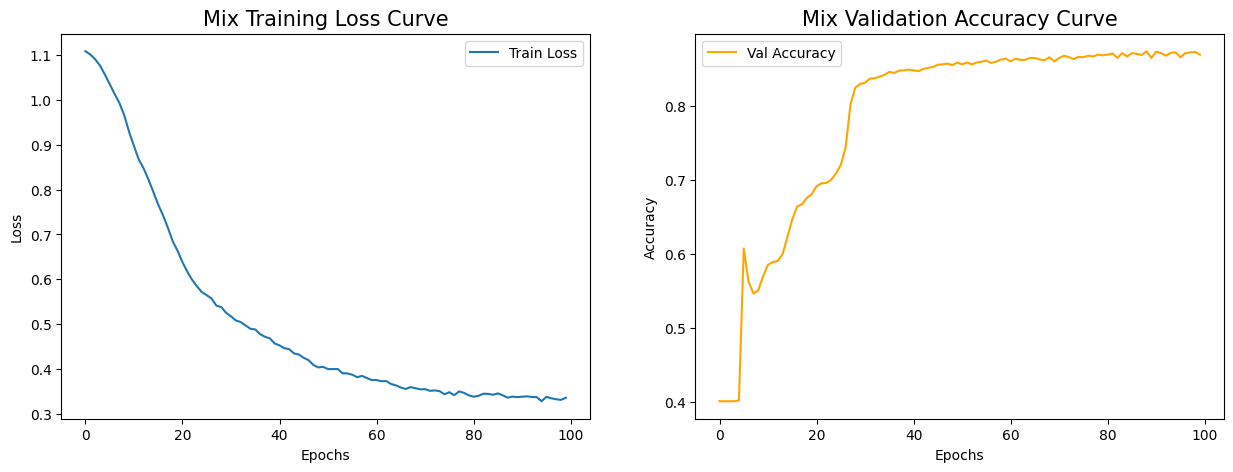

In [46]:
plot_loss_acc(train_lss_curve_mix, val_acc_curve_mix, 4, True)

In [25]:
# Print number of parameters
mix_total_params = sum(p.numel() for p in mix.parameters() if p.requires_grad)
print(f'Total number of parameters: {mix_total_params}')

Total number of parameters: 40963


### Link Prediction

Build a GNN-based model to predict the presence of citation links between publications.

In [42]:
# Utility functions to plot training loss and validation accuracy

link_models = {1:"GNN1", 2:"GNN2", 3:"GNN3"}

def plot_loss_acc_link(train_lss_curve, val_auc_curve, number, save = False):
  # Plot training loss and validation AUC
  plt.figure(figsize = (10, 5))
  plt.title(f"{link_models[number]}: training loss and validation AUC", fontsize = 15)
  plt.plot(range(n_epochs), train_lss_curve, label='Train Loss')
  plt.plot(range(n_epochs), val_auc_curve, label='Validation AUC')
  plt.xlabel('Epochs')
  plt.ylabel('Metrics')
  plt.legend()
  if save:
    plt.savefig(f'curves_{link_models[number]}.png')
  plt.show()
  return

#### GNN model 1 for link prediction

In [21]:
# My link prediction model 1
class LinkGNN1(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [22]:
# Train link predictor
def train_link_predictor(model, train_data, val_data, optimizer, criterion, n_epochs=100):
    train_lss_curve = []
    val_auc_curve = []

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()

        z = model.encode(train_data.x, train_data.edge_index)

        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index,
            num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1),
            method='sparse'
        )

        edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
        edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        train_lss_curve.append(loss.item())

        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)
        val_auc_curve.append(val_auc)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model, train_lss_curve, val_auc_curve

# Evaluate link predictor
@torch.no_grad()
def eval_link_predictor(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [24]:
# Split the data
split = RandomLinkSplit(
    num_val = 0.1,
    num_test = 0.1,
    is_undirected = True,
    add_negative_train_samples = False,
    neg_sampling_ratio = 1.0
)

train_data, val_data, test_data = split(data)
train_data, val_data, test_data = train_data.to(device), val_data.to(device), test_data.to(device)

In [25]:
print(train_data)
print(val_data)
print(test_data)

Data(x=[19717, 500], edge_index=[2, 70920], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717], edge_label=[35460], edge_label_index=[2, 35460])
Data(x=[19717, 500], edge_index=[2, 70920], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717], edge_label=[8864], edge_label_index=[2, 8864])
Data(x=[19717, 500], edge_index=[2, 79784], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717], edge_label=[8864], edge_label_index=[2, 8864])


In [27]:
lr = 0.005
wd = 5e-4
n_epochs = 100
hidden_channels = 128
out_channels = 64

link_model_1 = LinkGNN1(dataset.num_features, hidden_channels, out_channels).to(device)
optimizer = Adam(link_model_1.parameters(), lr=lr, weight_decay=wd)
criterion = nn.BCEWithLogitsLoss()

# training
link_model_1, train_lss_curve_1, val_auc_curve_1 = train_link_predictor(link_model_1, train_data, val_data, optimizer, criterion, n_epochs)

test_auc_1 = eval_link_predictor(link_model_1, test_data)
print(f"Test AUC: {test_auc_1:.2f}")

Epoch: 010, Train Loss: 0.640, Val AUC: 0.866
Epoch: 020, Train Loss: 0.616, Val AUC: 0.775
Epoch: 030, Train Loss: 0.571, Val AUC: 0.811
Epoch: 040, Train Loss: 0.534, Val AUC: 0.844
Epoch: 050, Train Loss: 0.531, Val AUC: 0.849
Epoch: 060, Train Loss: 0.527, Val AUC: 0.846
Epoch: 070, Train Loss: 0.522, Val AUC: 0.853
Epoch: 080, Train Loss: 0.523, Val AUC: 0.853
Epoch: 090, Train Loss: 0.523, Val AUC: 0.854
Epoch: 100, Train Loss: 0.520, Val AUC: 0.843
Test AUC: 0.86


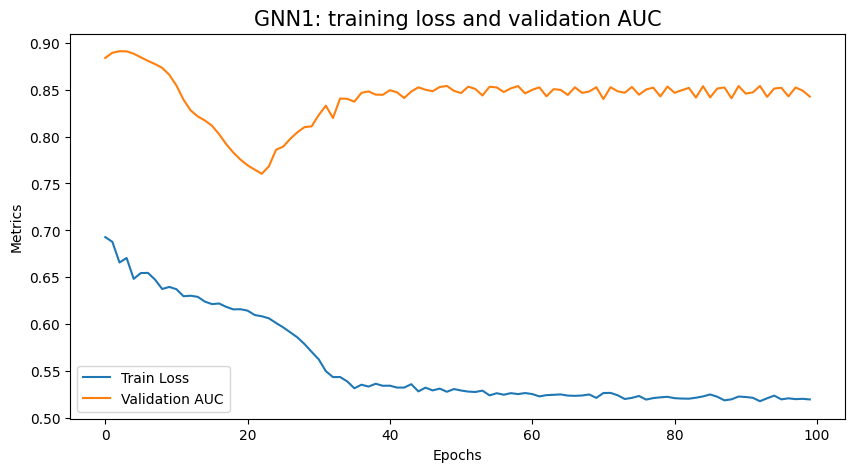

In [43]:
# Plot training loss and validation accuracy
plot_loss_acc_link(train_lss_curve_1, val_auc_curve_1, 1, save = True)

In [30]:
# Print number of parameters
link1_total_params = sum(p.numel() for p in link_model_1.parameters() if p.requires_grad)
print(f'Total number of parameters: {link1_total_params}')

Total number of parameters: 105408


#### GNN model 2 for link prediction

In [31]:
# My link prediction model 2
class LinkGNN2(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=1):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads)
        self.conv2 = GATConv(hidden_channels * num_heads, out_channels, heads=1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index).relu()
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [33]:
lr = 0.01
wd = 5e-4
n_epochs = 100
hidden_channels = 128
out_channels = 64

link_model_2 = LinkGNN2(dataset.num_features, hidden_channels, out_channels).to(device)
optimizer = Adam(link_model_2.parameters(), lr=lr, weight_decay=wd)
criterion = nn.BCEWithLogitsLoss()

# training
link_model_2, train_lss_curve_2, val_auc_curve_2 = train_link_predictor(link_model_2, train_data, val_data, optimizer, criterion, n_epochs)

test_auc = eval_link_predictor(link_model_2, test_data)
print(f"Test AUC: {test_auc:.2f}")

Epoch: 010, Train Loss: 0.640, Val AUC: 0.743
Epoch: 020, Train Loss: 0.632, Val AUC: 0.761
Epoch: 030, Train Loss: 0.624, Val AUC: 0.762
Epoch: 040, Train Loss: 0.614, Val AUC: 0.748
Epoch: 050, Train Loss: 0.610, Val AUC: 0.723
Epoch: 060, Train Loss: 0.609, Val AUC: 0.724
Epoch: 070, Train Loss: 0.610, Val AUC: 0.719
Epoch: 080, Train Loss: 0.608, Val AUC: 0.722
Epoch: 090, Train Loss: 0.609, Val AUC: 0.726
Epoch: 100, Train Loss: 0.610, Val AUC: 0.727
Test AUC: 0.72


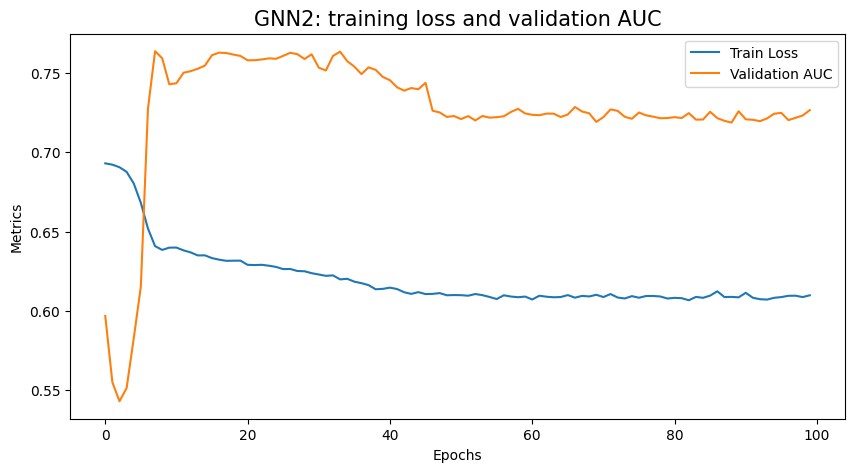

In [44]:
# Plot training loss and validation accuracy 
plot_loss_acc_link(train_lss_curve_2, val_auc_curve_2, 2, save = True)

In [36]:
# Print number of parameters
link2_total_params = sum(p.numel() for p in link_model_2.parameters() if p.requires_grad)
print(f'Total number of parameters: {link2_total_params}')

Total number of parameters: 72768


#### GNN model 3 for link prediction

In [37]:
# My link prediction model 3
class LinkGNN3(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=num_heads)
        self.conv3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads)
        self.conv4 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [38]:
lr = 0.01
wd = 5e-4
n_epochs = 100
hidden_channels = 128
out_channels = 64

link_model_3 = LinkGNN3(dataset.num_features, hidden_channels, out_channels).to(device)
optimizer = Adam(link_model_3.parameters(), lr=lr, weight_decay=wd)
criterion = nn.BCEWithLogitsLoss()

# training
link_model_3, train_lss_curve_3, val_auc_curve_3 = train_link_predictor(link_model_3, train_data, val_data, optimizer, criterion, n_epochs)

test_auc = eval_link_predictor(link_model_3, test_data)
print(f"Test AUC: {test_auc:.2f}")

Epoch: 010, Train Loss: 0.685, Val AUC: 0.878
Epoch: 020, Train Loss: 0.651, Val AUC: 0.883
Epoch: 030, Train Loss: 0.622, Val AUC: 0.841
Epoch: 040, Train Loss: 0.603, Val AUC: 0.770
Epoch: 050, Train Loss: 0.592, Val AUC: 0.777
Epoch: 060, Train Loss: 0.537, Val AUC: 0.828
Epoch: 070, Train Loss: 0.533, Val AUC: 0.837
Epoch: 080, Train Loss: 0.529, Val AUC: 0.830
Epoch: 090, Train Loss: 0.526, Val AUC: 0.831
Epoch: 100, Train Loss: 0.524, Val AUC: 0.828
Test AUC: 0.84


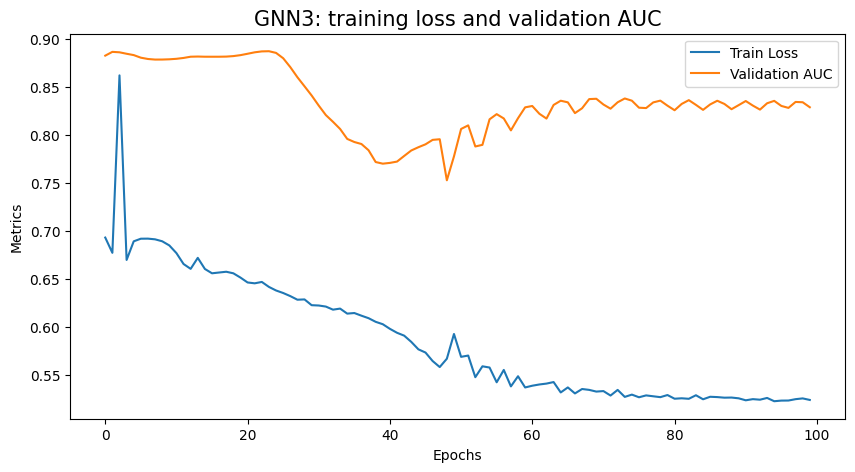

In [45]:
# Plot training loss and validation accuracy
plot_loss_acc_link(train_lss_curve_3, val_auc_curve_3, 3, save = True)

In [46]:
# Print number of parameters
link3_total_params = sum(p.numel() for p in link_model_3.parameters() if p.requires_grad)
print(f'Total number of parameters: {link3_total_params}')

Total number of parameters: 105920


---

## Evaluation metrics

### Node Classification

Measure the effectiveness of your models using metrics like accuracy,
precision, recall, and F1-score. <br>
Benchmark to surpass: $80.2\%$ in classification accuracy.

In [27]:
def classification_evaluation_metrics(model, graph, mask):
    model.eval()
    with torch.no_grad():
        out = model(graph)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == graph.y[mask]).sum().item()
        acc = correct / mask.sum().item()
    return acc, pred[mask], graph.y[mask]

def evaluation_report(name, model, data, test_mask):
    # Evaluate the model on the test set
    test_acc, y_pred, y_true = classification_evaluation_metrics(model, data, test_mask)

    # Calculate precision, recall, and F1-score
    # Accuracy comes from the previous functions
    # Note: need to ensure that the tensors are on CPU to use sklearn functions
    precision = precision_score(y_true.cpu(), y_pred.cpu(), average = 'weighted')
    recall = recall_score(y_true.cpu(), y_pred.cpu(), average = 'weighted')
    f1 = f1_score(y_true.cpu(), y_pred.cpu(), average = 'weighted')

    print(f"{name} evaluation metrics:\n")
    print(f"Test accuracy: {test_acc * 100:.2f}%")
    print(f"Precision:      {precision:.3f}")
    print(f"Recall:         {recall:.3f}")
    print(f"F1-score:       {f1:.3f}")
    return

In [28]:
evaluation_report('GCN', gcn, graph, graph.test_mask)

GCN evaluation metrics:

Test accuracy: 87.37%
Precision:      0.874
Recall:         0.874
F1-score:       0.874


In [29]:
evaluation_report('SAGE', sage, graph, graph.test_mask)

SAGE evaluation metrics:

Test accuracy: 89.22%
Precision:      0.893
Recall:         0.892
F1-score:       0.892


In [30]:
evaluation_report('GAT', gat, graph, graph.test_mask)

GAT evaluation metrics:

Test accuracy: 86.69%
Precision:      0.867
Recall:         0.867
F1-score:       0.867


In [31]:
evaluation_report('Mix', mix, graph, graph.test_mask)

Mix evaluation metrics:

Test accuracy: 88.05%
Precision:      0.881
Recall:         0.881
F1-score:       0.880


### Link Prediction
Evaluate your model’s proficiency at distinguishing between existing and
non-existing links using metrics such as AUC-ROC, F1-score, and ranking metrics (e.g., MRR, Hits@K). <br>
Benchmark to surpass: $91.0\%$ in AUC-ROC.

In [51]:
# Link prediction evaluation metrics

@torch.no_grad()
def link_prediction_metrics(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    edge_labels = data.edge_label.cpu().numpy()
    edge_preds = out.cpu().numpy()

    auc = roc_auc_score(edge_labels, edge_preds)
    f1 = f1_score(edge_labels, edge_preds.round())

    print('- Standard metrics:\n')
    print(f"AUC-ROC:  {auc:.4f}")
    print(f"F1-score: {f1:.4f}")

    return auc, f1

# Ranking metrics
@torch.no_grad()
def ranking_metrics(model, data, k = 10):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    edge_labels = data.edge_label.cpu().numpy()

    preds = out.cpu().numpy()
    sorted_indices = preds.argsort()[::-1]

    sorted_edge_labels = edge_labels[sorted_indices]
    hits = sorted_edge_labels[:k].sum()
    mrr = (1 / (sorted_indices[:k] + 1)).sum()
    print('- Ranking metrics:\n')
    print(f"MRR:      {mrr:.4f}")
    print(f"Hits@{k}: {hits}")

    return mrr, hits

def link_evaluation_report(number, model, test_data, k):
    print(f"GNN link model {number} evaluation metrics -------\n")
    auc, f1 = link_prediction_metrics(model, test_data)
    print('')
    mrr, hits = ranking_metrics(model, test_data, k)
    print('-------------------------------------------')
    return

In [52]:
# Evaluate model 1
link_evaluation_report(1, link_model_1, test_data, k=10)

GNN link model 1 evaluation metrics -------

- Standard metrics:

AUC-ROC:  0.8551
F1-score: 0.7499

- Ranking metrics:

MRR:      0.0107
Hits@10: 10.0
-------------------------------------------


In [53]:
# Evaluate model 2
link_evaluation_report(2, link_model_2, test_data, k=10)

GNN link model 2 evaluation metrics -------

- Standard metrics:

AUC-ROC:  0.7245
F1-score: 0.6684

- Ranking metrics:

MRR:      0.0369
Hits@10: 10.0
-------------------------------------------


In [54]:
# Evaluate model 3
link_evaluation_report(3, link_model_3, test_data, k=10)

GNN link model 3 evaluation metrics -------

- Standard metrics:

AUC-ROC:  0.8357
F1-score: 0.7387

- Ranking metrics:

MRR:      0.0104
Hits@10: 10.0
-------------------------------------------
